# Recommendation engines explained

We start by importing the relevant [Apache Spark](https://spark.apache.org/) modules and create a Spark session:

In [1]:
%matplotlib inline

from pyspark import SparkContext, SparkConf
from pyspark.sql import Row, SparkSession

spark = SparkSession.builder \
        .master("local") \
        .appName("recommender") \
        .config("spark.sql.crossJoin.enabled", "true") \
        .getOrCreate()

## The MovieLens dataset

The MovieLens dataset (already available with this notebook, originally [here](https://grouplens.org/datasets/movielens/)) is a popular dataset used in recommendation engines research.
In this workshop we will use the "small" variant, consisting of 20000263 ratings for 27278 movies by 138493 users.
This dataset consist of several CSV files, namely
 * A ratings data file (`ratings.csv`)
 * A tags data file (`tags.csv`)
 * A movies data file (`movies.csv`)
 * A links data file (`links.csv`)
 * A tag genome (`genome-scores.csv` and `genome-tags.csv`)
 
 For the scope of this workshop, we are mainly interest in the rating and movies data files, which have, respectively, the following structure:
 The ratings data:
 * `userId`, a unique numerical user id
 * `movieId`, a unique numerical movie id
 * `rating`, a numerical rating, as an integer from $0$ to $5$
 * `timestamp`, a numerical timestamp (not used in this exercise)
 The movies data:
 * `movieId`, as above
 * `title`, the movie title
 * `genres` a string label with the movie genre (as listed [here](http://files.grouplens.org/datasets/movielens/ml-20m-README.html)).
 
 ### Loading the data
 
 We start by using Apache Spark's built in functionality to load text files into the Spark cluster, `.textFile()` (documented [here](http://spark.apache.org/docs/2.1.0/api/python/pyspark.html#pyspark.SparkContext.textFile)), which will return an `RDD` of strings.
 Since `.textFile()` will read each row in the CSV file as an RDD entry, we further process it by then splitting each row into a list of CSV entries and keep only the relevant fields (i.e. `userId`, `movieId` and `rating` for the ratings, and `movieId` and `title` for the movies file).
 
 We then create a Spark [dataframe](https://spark.apache.org/docs/latest/sql-programming-guide.html) containing the entries.

In [2]:
def load_data(path, header, token_fun):
    """Loads the CSV file, strips the header and keeps only the specified fields"""
    rows = spark.sparkContext.textFile(path).filter(lambda x: x!=header).map(lambda x: x.split(",")).map(token_fun)
    # create a Spark dataframe from the RDDs
    return spark.createDataFrame(rows).cache()
    
    
# Load the movie data (movie id, title)
movies = load_data('ml-latest-small/movies.csv', 
                   'movieId,title,genres', 
                   lambda tokens: Row(item=int(tokens[0]),title=tokens[1]))

# Load the ratings (user id, movie id, rating)
ratings = load_data('ml-latest-small/ratings.csv', 
                    'userId,movieId,rating,timestamp', 
                    lambda tokens: Row(user=int(tokens[0]), item=int(tokens[1]), rating=float(tokens[2])))

In [3]:
print("Number of movies: {}".format(movies.count()))
print("Number of ratings: {}".format(ratings.count()))
movies.take(5)

Number of movies: 9742
Number of ratings: 100836


[Row(item=1, title='Toy Story (1995)'),
 Row(item=2, title='Jumanji (1995)'),
 Row(item=3, title='Grumpier Old Men (1995)'),
 Row(item=4, title='Waiting to Exhale (1995)'),
 Row(item=5, title='Father of the Bride Part II (1995)')]

We can now start by exploring the data.
Let's look at the ratings distribution:

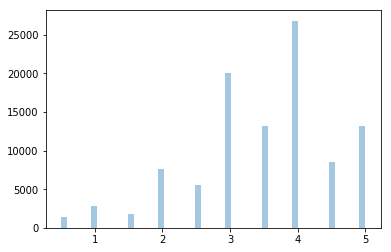

In [4]:
import seaborn as sns

r = ratings.select('rating').collect()
sns.distplot(r, kde=False)

We can see that most of the ratings are $4$ starts, followed by $3$ and $3.5$ stars. Users generally do not give very low ratings (e.g. $0.5$, $1$).

Let's try to see now the distribution of the number of ratings per user. That is, so user give many ratings on average?

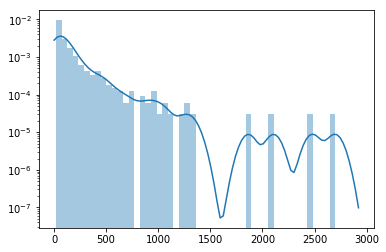

In [6]:
ratings_per_user = ratings.groupBy("user").count()
sns.distplot(ratings_per_user.select("count").collect(), hist_kws={'log':True}, kde_kws={'clip': (1.0, 3000.0)})

We can see that we have "super users", i.e. users that give more than 2000 ratings!
From this histogram its not easy to see how many they are, so lets find out.

In [7]:
from pyspark.sql.functions import col

ratings_per_user.filter(col('count') > 1500).groupBy('user').count().agg({"count":"sum"}).show()

+----------+
|sum(count)|
+----------+
|         4|
+----------+



So we only have $4$ "super" users. Let's now see how many users we have with less that 100 ratings:

In [8]:
ratings_per_user.filter(col('count') < 200).groupBy('user').count().agg({"count":"sum"}).show()

+----------+
|sum(count)|
+----------+
|       476|
+----------+



We can see that the vast majority of users gave less that $200$ ratings, which is a sensible number.

What about the movies? Do movies tend to have the same number of reviews or not? We can check by running:

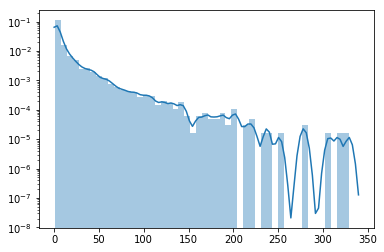

In [9]:
ratings_per_movie = ratings.groupBy("item").count()
sns.distplot(ratings_per_movie.select("count").collect(), hist_kws={'log':True}, kde_kws={'clip': (0, 3000.0)})

In [10]:
ratings_per_movie.filter(col('count') < 2).groupBy('item').count().agg({"count":"sum"}).show()

+----------+
|sum(count)|
+----------+
|      3446|
+----------+



## Training the model

TODO: Explain the model

To train Spark's ALS model, we need to perform a few steps.
The first step is to define a metric to quantify "how good" our model is. This is done by chosing an error measure, which typically is the _mean squared error_ (MSE). The mean square error is formally defined by

$$
\text{MSE} = \frac{1}{N}\sum_{i=1}^{N}\epsilon_i^2, \qquad \epsilon_i = r_i - \hat{r}_i.
$$

That is, we first calculate the difference, $\epsilon_i$, between each pair of true rating ($r_i$) and it's corresponding _predicted_ rating ($\hat{r}_i$) and then calculated the average of the square of these errors. As example, consider a list of ratings `r1` and corresponding predictiong `r2`:

In [11]:
r1 = [4.5, 3.0, 1.0, 5.0, 4.0]
r2 = [4.56, 2.9, 1.1, 4.9, 3.2]

In [12]:
def mse(r, p):
    return sum([(pair[0] - pair[1])**2 for pair in zip(r, p)]) / len(r)

print("MSE = {}".format(mse(r1, r2)))

MSE = 0.13471999999999992


Since we've established our error measure, we can proceed to the next step.
We now need to split our data into a _training_, _test_ and _validation_ subsets.
We will use respectively the proportions 63%, 18% and 18%.

In [13]:
def split_sets(ratings, proportions):
    split = ratings.randomSplit(proportions, seed=42)
    return {'training': split[0], 'validation': split[1], 'test': split[2]}
    
sets = split_sets(ratings, [0.63212056, 0.1839397, 0.1839397])
print("Training dataset size = {}".format(sets['training'].count()))
print("Validation dataset size = {}".format(sets['validation'].count()))
print("Test dataset size = {}".format(sets['test'].count()))

Training dataset size = 63952
Validation dataset size = 18464
Test dataset size = 18420


Let's try an ALS model with some arbitrary parameters:

In [28]:
from pyspark.ml.recommendation import ALS

simple_als = ALS(maxIter=5, regParam=0.01, rank=3, coldStartStrategy="drop")
%time simple_model = simple_als.fit(sets['training'])

CPU times: user 21.6 ms, sys: 5.87 ms, total: 27.5 ms
Wall time: 2 s


As we can see from the above, the training was quite quick ($2$ seconds in my case, yours may be different).

We can now calculate the MSE for this model, with the test datasets. To do so, we use the [Spark's](http://spark.apache.org/docs/2.2.0/api/python/pyspark.ml.html#pyspark.ml.evaluation.RegressionEvaluator) `RegressionEvaluator` class. In this class we can specify the error measure (`mse`, `rmse`, etc.) and the names of the labels (in our case the ratings) and the predictions columns.

In [31]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(
    metricName="mse",
    labelCol="rating",
    predictionCol="prediction")

mse = evaluator.evaluate(model.transform(sets['test']))
print("MSE = {}".format(mse))

MSE = 0.9840127972425159


### Parameter estimation

We add the `coldStartStrategy` to the ALS class so that we automatically drop any `NaN` predictions.

In [ ]:
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder

sub_als = ALS(coldStartStrategy="drop", seed=42)

sub_param_grid = ParamGridBuilder() \
    .addGrid(sub_als.rank, list(range(1, 10))) \
    .build()

sub_evaluator = RegressionEvaluator(
    metricName="mse",
    labelCol="rating",
    predictionCol="prediction")

sub_tvs = TrainValidationSplit(
    estimator=sub_als,
    estimatorParamMaps=sub_param_grid,
    evaluator=sub_evaluator,
    collectSubModels=True
)

sub_model = sub_tvs.fit(ratings.sample(0.005, seed=42).cache())

In [ ]:
print("Best rank (subset) = {}".format(sub_model.bestModel.rank))

In [ ]:
sub_test = ratings.sample(0.005, seed=42).cache()

sub_ranks = [model.rank for model in sub_model.subModels]
sub_mses = [sub_evaluator.evaluate(model.transform(sub_test)) for model in sub_model.subModels]

sns.pointplot(x=sub_ranks, y=sub_mses)

In [ ]:
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator

als = ALS(coldStartStrategy="drop")

param_grid = ParamGridBuilder() \
    .addGrid(als.rank, [6, 8, 10, 12]) \
    .addGrid(als.maxIter,[6, 8, 10, 12]) \
    .build()

evaluator = RegressionEvaluator(
    metricName="mse",
    labelCol="rating",
    predictionCol="prediction")

tvs = TrainValidationSplit(
    estimator=als,
    estimatorParamMaps=param_grid,
    evaluator=evaluator,
)

model = tvs.fit(sets['training'])

In [ ]:
prediction = model.transform(sets['test'])


# prediction = prediction.withColumn("prediction", F.abs(F.round(prediction["prediction"],0)))

prediction.alias('p').join(movies.alias('m'), col('p.item') == col('m.item')) \
    .select([col('p.user'), col('m.title'), col('p.prediction'), col('p.rating')]).show(100, truncate=False)

In [ ]:
print("MSE = {}".format(sub))

In [ ]:
errors = prediction.withColumn('error', col('prediction')-col('rating')).select('error').collect()
ax = sns.distplot(errors, rug=True, hist=True)
ax.set_xlim(0, 5)

## Prediction

Now that we have a trained model, several methods are available to us.
For instance, we can predict the five movies for each user:

In [ ]:
model.bestModel.recommendForAllUsers(10).show(10)

Or the top three most likely users to like each movie:

In [ ]:
model.bestModel.recommendForAllItems(3).show(10)

### Your personal recommendations

We can now used the model as our personal movie recommender!

You will create a new user profile for yourself and start adding your own ratings.
Based on these ratings, you will then be able to predict ratings for movies you haven't seen it (at least rated).

First, you'll determine your `user` id:

In [ ]:
new_user_id = ratings.groupBy().max('user').first()['max(user)'] + 1
print("New user id = {}".format(new_user_id))

Next, we create a list of tuples (pairs) consisting of a `item` id and our own `rating`.
The following list is just a example, if you want to create your own list, evaluate the following method with a partial name of movie for which you want to find the id and replace it on the list below.

In [ ]:
from pyspark.sql.functions import lower

def find_movie_id(partial_title):
    movies.where(lower(col('title')).like("%{}%".format(partial_title.lower())))\
    .show(truncate=False)
    
find_movie_id('runner')

After finding your favourite movies, replace them (along with your rating) on the following list:

In [ ]:
my_ratings = [(484, 1), # Sorry, I didn't really liked Lassie
(485, 4), # Last Action Hero, it's a guilty pleasure
(492, 4), # Manhattan Murder Mystery, a great movie
(519, 1), # RoboCop 3, what a way to spoil a great franchise
(541, 5), # Blade Runner, enough said
(2968, 5), # Time Bandits, a classic
(587, 1), # eeech, Ghost
(608, 5), # Fargo, another classic
(680, 4), # Alphaville, great, but not easy
(741, 4), # Ghost in the Shell, always fun
(750, 5), # Dr. Strangelove, again, enough said
(784, 1), # Cable Guy. not. funny.
(1288, 5), # This Is Spinal Tap. essential.
(2067, 2), # Doctor Zhivago, classic but not my thing.
(3081, 3), # Sleepy Hollow enjoyable
(4848, 5), # Mulholland Drive. What? Yes!
(4878, 3), # Donnie Darko, twas ok
(4973, 4), # Amelie 
(5147, 5), # Wild Strawberries
(6383, 1)] # 2 Fast 2 Furious              

my_ratings_df = spark.createDataFrame([Row(user=new_user_id, item=r[0], rating=r[1]) for r in my_ratings])
my_ratings_df.show()

In [ ]:
new_ratings = ratings.union(my_ratings_df)

In [ ]:
best_rank = model.bestModel.rank
best_iterations = model.bestModel._java_obj.parent().getMaxIter()
new_model = ALS(rank=best_rank, maxIter=best_iterations, coldStartStrategy="drop").fit(new_ratings)

Now let's predict the ratings for the movies you _haven't_ seen.
We start by creating a dataframe consisting of all the movie ids _except_ the ones you have rated previously.

In [ ]:
unseen_movies = movies.alias('m').join(my_ratings_df.alias('r'), col('m.item') == col('r.item'), how='left_anti').select('item')
unseen_movies.show(10)
print("Number of unseen movies = {}".format(unseen_movies.count()))

We now create a dataframe consisting of your `user` id and the `item` id of each movie you haven't seen.

In [ ]:
from pyspark.sql.functions import lit

unseen_movies_user = unseen_movies.withColumn("user", lit(new_user_id))

In [ ]:
unseen_ratings = new_model.transform(unseen_movies_user)
unseen_ratings.show(10)

In [ ]:
unseen_ratings_titles = unseen_ratings.alias('r')\
                        .join(movies.alias('m'), col('r.item') == col('m.item'))\
                        .select(['user', 'title', 'prediction'])
unseen_ratings_titles.show(10, truncate=False)

In [ ]:
unseen_ratings_titles.orderBy(col('prediction').desc()).show(20)

## Implicit data
For the implicit case we will use the data from the [Book Crossing Dataset](http://www2.informatik.uni-freiburg.de/~cziegler/BX/).

In [ ]:
implicit_ratings_raw = spark.sparkContext.textFile('BX-Book-Ratings.csv')\
                   .filter(lambda x: x!='"User-ID";"ISBN";"Book-Rating"')\
                   .map(lambda x: x.replace('"',"")) \
                   .map(lambda x:x.split(";"))\
                   .map(lambda x:(int(x[0]), str(x[1]), int(x[2])))

In [ ]:
implicit_ratings_raw.take(10)

In [ ]:
implicit_ratings = implicit_ratings_raw.filter(lambda x: x[2] == 0)

In [ ]:
implicit_ratings.take(10)

In [ ]:
# Extract unique isbns.
isbns=implicit_ratings.map(lambda x:x[1]).distinct()
#Associates an integer with each unique isbn.
isbns_with_indices=isbns.zipWithIndex() 
#sets isbn as the key
reordered_implicit_ratings = implicit_ratings.map(lambda x:(x[1], (x[0], x[2]))) 
joined = reordered_implicit_ratings.join(isbns_with_indices) #joins with indexes 
joined.take(10)

In [ ]:
#The data above is of the form :
    #(isbn, ((userid, rating), isbn-id-integer))
#We use the map function to get to the form :
    #(user id, isbn-id-integer, rating)
#This is the form expected by the ALS function
ratings_int_nice = joined.map(lambda x: (x[1][0][0], x[1][1], x[1][0][1]))
ratings_int_nice.take(10)

In [ ]:
#Need 1s not 0s. since the matrix is singular if 0s. 
#i.e. we use '1' to indicate response, not 0.
ratings_ones = ratings_int_nice.map(lambda x: Row(user=x[0], item=x[1], rating=1))
implicit_ratings = spark.createDataFrame(ratings_ones).cache()
implicit_ratings.show()

In [ ]:
implicit_sets = split_sets(implicit_ratings, [0.63212056, 0.1839397, 0.1839397])
print("Training dataset size (implicit) = {}".format(implicit_sets['training'].count()))
print("Validation dataset size (implicit) = {}".format(implicit_sets['validation'].count()))
print("Test dataset size = {} (implicit)".format(implicit_sets['test'].count()))

In [ ]:
ials = ALS(coldStartStrategy="drop", implicitPrefs=True, nonnegative=True)

iparam_grid = ParamGridBuilder() \
    .addGrid(ials.rank, [6, 8, 10]) \
    .addGrid(ials.maxIter,[1, 3]) \
    .build()

ievaluator = RegressionEvaluator(
    metricName="mse",
    labelCol="rating",
    predictionCol="prediction")

itvs = TrainValidationSplit(
    estimator=ials,
    estimatorParamMaps=iparam_grid,
    evaluator=ievaluator,
)

imodel = itvs.fit(implicit_sets['training'])

In [ ]:
iprediction = imodel.transform(implicit_sets['test'])

In [ ]:
iprediction.show()

In [ ]:
ibest_rank = imodel.bestModel.rank
ibest_iterations = imodel.bestModel._java_obj.parent().getMaxIter()
print("Best rank (implicit) = {}".format(ibest_rank))
print("Best iterations (implicit) = {}".format(ibest_iterations))
new_imodel = ALS(rank=ibest_rank, 
                 maxIter=ibest_iterations, 
                 coldStartStrategy="drop", 
                 nonnegative=True).fit(implicit_ratings)

In [ ]:
seen = implicit_ratings.filter(col('user')==8).select('item')
unseen_books = implicit_ratings.alias('r')\
    .join(seen.alias('s'), col('r.item') == col('s.item'), how='left_anti')\
    .select('item').distinct()\
    .withColumn('user', lit(8))\
    .cache()
unseen_books.show(10)
print("Number of unseen books = {}".format(unseen_books.count()))

In [ ]:
new_imodel.transform(unseen_books).orderBy(col('prediction').desc()).show(20)

In [ ]:
print("MSE (implicit) = {}".format(ievaluator.evaluate(iprediction)))